<a href="https://colab.research.google.com/github/ValentinaPasqual/mythLOD_for_KOCH/blob/main/mythConversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>FIRST THINGS FIRST: WHAT ARE WE DOING?</b>

---





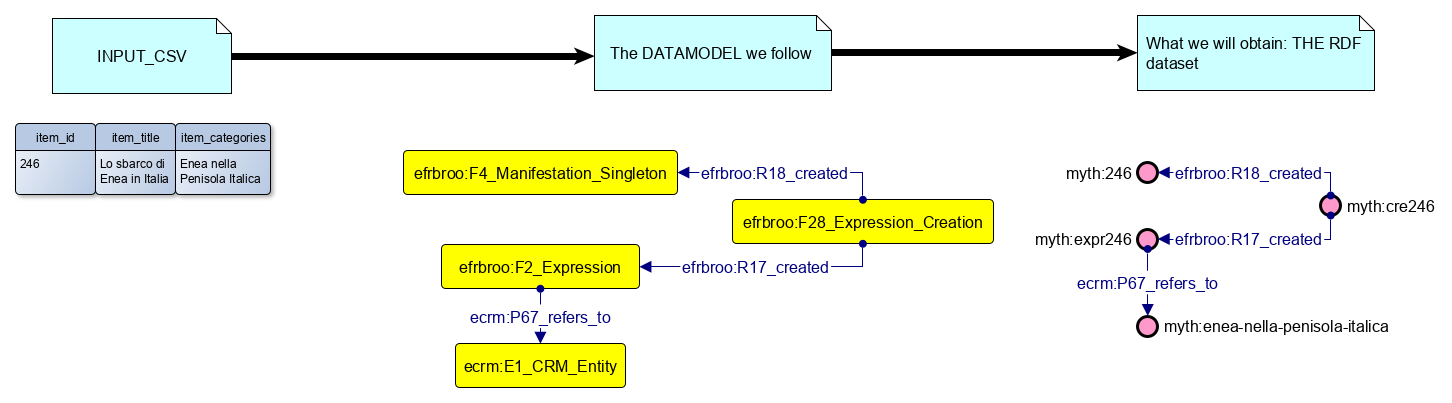

Install required libraries to parse CSV (pandas) and RDF (rdflib)

In [208]:
!pip install rdflib
!pip install pandas

Import required modules from installed libraries

In [209]:
from rdflib import Graph, Literal, RDF, URIRef, Namespace # basic RDF handling
from rdflib.namespace import FOAF , XSD, RDF, RDFS # most common namespaces
import pandas as pd
import re
import unicodedata

Read the CSV from my Github repository

In [210]:
# the dataset can be found on my Github
df = pd.read_csv('https://raw.githubusercontent.com/ValentinaPasqual/mythLOD_for_KOCH/main/example.csv', sep=';')  

df

,item_id,item_title,item_categories
0,246,Lo sbarco di Enea in Italia,Enea nella Penisola Italica
1,854,Prometeo,"Prometeo, Miti di Fondazione"
2,942,Flora in giardino,"Flora, Gli Dèi"
3,3997,Pan e Siringa,"Pan, Gli Dei"
4,2149,Amore divino e profano,"Eros, Gli Dèi"


Definition of simple functions to clear URIs 


Not allowed:
- Spaces 
- Accents 
- Punctuation

Allowed:
- Camel Case

In [211]:
# clear URIs

word_regex_pattern = re.compile("[^A-Za-z0-9]+")

def camel(chars): # URI in Camel Case - useful for english version
  words = word_regex_pattern.split(chars)
  return "".join(w.lower().strip() if i is 0 else w.title() for i, w in enumerate(words))

def diacritics(chars): # get rid of diacritics and normalise text - useful for italian language
  normalized = unicodedata.normalize("NFKD", chars)
  return "".join(c for c in normalized if unicodedata.category(c) != "Mn")

Define an empty Graph (to store our RDF data from the csv) and declare ontologies prefixes

In [212]:
g = Graph() # we create the graph to store triples

# declaring prefixes so that we can reuse them instead of writing down the whole URI anytime
efrbroo = Namespace("http://erlangen-crm.org/efrbroo/") 
myth = Namespace("https://w3id.org/mythlod/")
dct = Namespace("http://purl.org/dc/terms/")
ecrm = Namespace("http://erlangen-crm.org/current/")

Bind namespaces: in this way we can use variables (e.g. myth) instead of full URIs (e.g. "https://w3id.org/mythlod/") in the code

In [213]:
g.bind('efrbroo', efrbroo) # we bind namespaces to the graph (g)
g.bind('myth', myth)
g.bind('dct', dct)
g.bind('ecrm', ecrm)

Add all entities for "item_id" and "item_title"

In [214]:
# add item_id and item_title to the RDF 

for (idx, row) in df.iterrows():
  # first, we work on titles and ids in df
  item_id = (str(row.item_id).strip())
  item_title = (row.item_title).strip()

  # we create first the URIRefs i will put in the triples 
  manifestation = URIRef(myth + 'manif' + item_id)
  expression = URIRef(myth + 'expr' + item_id)
  expr_creation = URIRef(myth + 'cre' + item_id)

  # now we can create the triples reusing the schema we choose and the URIs we created
  # first we declare that an entity belongs to a class
  g.add((manifestation, RDF.type, efrbroo.F4_Manifestation_Singleton))
  g.add((expression, RDF.type, efrbroo.F2_Expression))
  g.add((expr_creation, RDF.type, efrbroo.F28_Expression_Creation))

  # we go on with adding triples to the graph but creating also relations between entities
  g.add((expr_creation, efrbroo.R17_created, expression))
  g.add((expr_creation, efrbroo.R18_created, manifestation))
  g.add((manifestation, dct.title, (Literal(item_title, datatype=XSD.string))))
  
for s,p,o in g.triples((None, None, None)):
  print(s,p,o)

https://w3id.org/mythlod/cre942 http://erlangen-crm.org/efrbroo/R18_created https://w3id.org/mythlod/manif942
https://w3id.org/mythlod/cre2149 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://erlangen-crm.org/efrbroo/F28_Expression_Creation
https://w3id.org/mythlod/expr246 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://erlangen-crm.org/efrbroo/F2_Expression
https://w3id.org/mythlod/cre854 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://erlangen-crm.org/efrbroo/F28_Expression_Creation
https://w3id.org/mythlod/manif246 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://erlangen-crm.org/efrbroo/F4_Manifestation_Singleton
https://w3id.org/mythlod/expr3997 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://erlangen-crm.org/efrbroo/F2_Expression
https://w3id.org/mythlod/cre246 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://erlangen-crm.org/efrbroo/F28_Expression_Creation
https://w3id.org/mythlod/manif2149 http://purl.org/dc/terms/title Amore divino e prof

Add all entities for "item_categories"

In [215]:
# In this case, for each category, we want to create a label and a URI

for (idx, row) in df.iterrows():

  # We redifine expression, so we can match each expression to the respective(s) cateogory(ies)
  expression = URIRef(myth + 'expr' + str(row.item_id).strip())

  cat_list = []
  cat_list = row.item_categories.split(',')

  for c in cat_list:
    uri_partial = diacritics(c) # the function we defined previousely
    uri = camel(uri_partial)
    label = c.strip()

    # again, we create entities
    categ_uri = URIRef(myth + uri)

    # we add the labels
    g.add((categ_uri, RDFS.label, (Literal(label, datatype=XSD.string))))

    # define them and make connections between them 
    g.add((categ_uri, RDF.type, ecrm.E1_CRM_Entity)) # we define the category 
    g.add((expression, ecrm.P67_refers_to, categ_uri)) # now we say that the item (expression) represents a category 

for s,p,o in g.triples((None, ecrm.P67_refers_to, None)):   
  print(s,p,o)

for s,p,o in g.triples((None, RDFS.label, None)):   
  print(s,p,o)


https://w3id.org/mythlod/expr246 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/eneaNellaPenisolaItalica
https://w3id.org/mythlod/expr854 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/prometeo
https://w3id.org/mythlod/expr854 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/MitiDiFondazione
https://w3id.org/mythlod/expr942 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/flora
https://w3id.org/mythlod/expr942 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/GliDei
https://w3id.org/mythlod/expr3997 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/GliDei
https://w3id.org/mythlod/expr2149 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/GliDei
https://w3id.org/mythlod/expr3997 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/pan
https://w3id.org/mythlod/expr2149 http://erlangen-crm.org/current/P67_refers_to htt

Save the graph in Turtle serialisation

In [216]:
# we save the RDF in Turtle serialisation
output_path = "/content/sample_data/mythTurtle.ttl"

file = g.serialize(output_path, format='ttl')
# print(g.serialize(format='ttl'))

<b>We can do exaclty the same thing but using quads instead of triples.</b> 

Triple structure: subject, predicate, object
Quads structure: subject, predicate, object, context

Context is always an URI and it acts like a sort of "container" for the triple. In this way you can specify that a triple has some meaning in a particular context. It is very useful when you express subjective information (as in mythLOD case). For example with quads you can express something like:

1) <code>myth:expr854 ecrm:P67_refers_to myth:enea myth:valentina_opinion1</code>

2) <code>myth:expr854 ecrm:P67_refers_to myth:enea myth:bruno_opinion1</code>

This means that me and Bruno are expressing the interpretation over the artifact, but mantaining the provenance information.  

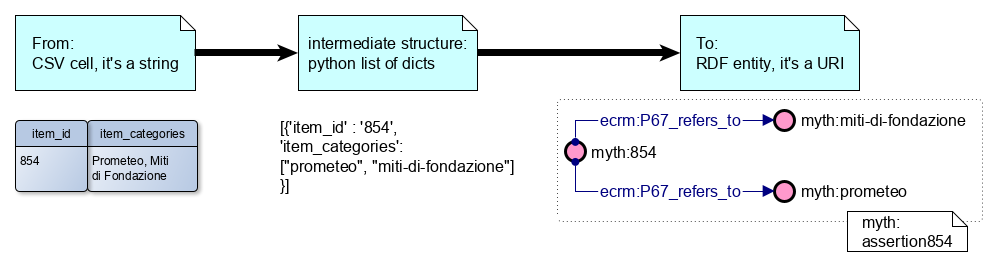

In [218]:
from rdflib import ConjunctiveGraph

gc = ConjunctiveGraph () 

# now we bind the namespaces to gc
gc.bind('efrbroo', efrbroo) # we bind namespaces to the graph
gc.bind('myth', myth)
gc.bind('dct', dct)
gc.bind('ecrm', ecrm)

In [219]:
# CREATING A RDF WITH QUADS = SUBJ, PRED, OBJ, CONTEXT

for (idx, row) in df.iterrows():
  # first, we work on titles and ids in df
  item_id = (str(row.item_id).strip())
  item_title = (row.item_title).strip()
  factual_data_bag = URIRef(myth + 'factual_data_bag')

  # we create first the URIRefs i will put in the triples 
  manifestation = URIRef(myth + 'manif' + item_id)
  expression = URIRef(myth + 'expr' + item_id)
  expr_creation = URIRef(myth + 'cre' + item_id)

  # now we can create the triples reusing the schema we choose and the URIs we created
  # first we declare that an entity belongs to a class
  gc.add((manifestation, RDF.type, efrbroo.F4_Manifestation_Singleton, factual_data_bag))
  gc.add((expression, RDF.type, efrbroo.F2_Expression, factual_data_bag))
  gc.add((expr_creation, RDF.type, efrbroo.F28_Expression_Creation, factual_data_bag))

  # we go on with adding triples to the graph but creating also relations between entities
  gc.add((expr_creation, efrbroo.R17_created, expression, factual_data_bag))
  gc.add((expr_creation, efrbroo.R18_created, manifestation, factual_data_bag))
  gc.add((manifestation, dct.title, (Literal(item_title, datatype=XSD.string)), factual_data_bag))
  
for s,p,o,c in gc.quads((None, None, None, None)):
  print(s,p,o,c)


https://w3id.org/mythlod/cre942 http://erlangen-crm.org/efrbroo/R18_created https://w3id.org/mythlod/manif942 <https://w3id.org/mythlod/factual_data_bag> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory'].
https://w3id.org/mythlod/cre2149 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://erlangen-crm.org/efrbroo/F28_Expression_Creation <https://w3id.org/mythlod/factual_data_bag> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory'].
https://w3id.org/mythlod/expr246 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://erlangen-crm.org/efrbroo/F2_Expression <https://w3id.org/mythlod/factual_data_bag> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory'].
https://w3id.org/mythlod/cre854 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://erlangen-crm.org/efrbroo/F28_Expression_Creation <https://w3id.org/mythlod/factual_data_bag> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory'].
https://w3id.org/mythlod/manif246 http://www.w3.or

In [220]:
# In this case, for each category, we want to create a label and a URI

factual_data_bag = URIRef(myth + 'factual_data_bag')

for (idx, row) in df.iterrows():

  # We redifine expression, so we can match each expression to the respective(s) cateogory(ies)
  expression = URIRef(myth + 'expr' + str(row.item_id).strip())
  assertion_bag = URIRef(myth + 'assertion' + str(row.item_id))

  cat_list = []
  cat_list = row.item_categories.split(',')

  for c in cat_list:
    uri_partial = diacritics(c) # the function we defined previousely
    uri = camel(uri_partial)
    label = c.strip()

    # again, we create entities
    categ_uri = URIRef(myth + uri)

    # we add the labels
    gc.add((categ_uri, RDFS.label, (Literal(label, datatype=XSD.string)), factual_data_bag))

    # define them and make connections between them 
    gc.add((categ_uri, RDF.type, ecrm.E1_CRM_Entity, factual_data_bag)) # we define the category 
    gc.add((expression, ecrm.P67_refers_to, categ_uri, assertion_bag)) # now we say that the item (expression) represents a category 

for s,p,o,c in gc.quads((None, ecrm.P67_refers_to, None, None)):   
  print(s,p,o,c)

for s,p,o,c in gc.quads((None, RDFS.label, None, None)):   
  print(s,p,o)

https://w3id.org/mythlod/expr246 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/eneaNellaPenisolaItalica <https://w3id.org/mythlod/assertion246> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory'].
https://w3id.org/mythlod/expr854 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/prometeo <https://w3id.org/mythlod/assertion854> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory'].
https://w3id.org/mythlod/expr854 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/MitiDiFondazione <https://w3id.org/mythlod/assertion854> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory'].
https://w3id.org/mythlod/expr942 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod/flora <https://w3id.org/mythlod/assertion942> a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory'].
https://w3id.org/mythlod/expr942 http://erlangen-crm.org/current/P67_refers_to https://w3id.org/mythlod

In [223]:
output_path = "/content/sample_data/mythTriG.trig"

gc.serialize(output_path, format='trig')
#print(gc.serialize(format='trig'))

<Graph identifier=N3eddea5276964a7fa37432b09d64eea8 (<class 'rdflib.graph.ConjunctiveGraph'>)>

*Now*, in the repository (github or drive as you prefer) you can look at the difference between the two datasets. What do you think?